# Autoencoders

<p>
CAS on Advanced Machine Learning <br>
Data Science Lab, University of Bern, 2024<br>
Prepared by Dr. Mykhailo Vladymyrov.

</p>

This work is licensed under a <a href="https://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

# Libs and utils

In [ ]:
# on colab:
!pip install einops


In [1]:
import os

# set env var to allow duplicated lib
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import einops as eo
import pathlib as pl

import matplotlib.cm as cm
from matplotlib import collections  as mc
from matplotlib import animation
%matplotlib inline

from scipy.stats import norm
from scipy.stats import entropy

import pandas as pd
import pickle
from PIL import Image
from time import time as timer
#import umap

from IPython.display import HTML
from IPython.display import Audio
import IPython

import tqdm.auto as tqdm

import torch
from torchvision import datasets, transforms
from torch import nn
from torch import optim
import torch.nn.functional as F

import sys
is_colab = 'google.colab' in sys.modules


In [2]:
# get mean and std of an array with numpy:
def get_mean_std(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    return x_mean, x_std

# get min and max of an array with numpy:
def get_min_max(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return x_min, x_max

def is_iterable(obj):
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True

def type_len(obj):
    t = type(obj)
    if is_iterable(obj):
        sfx = f', shape: {obj.shape}' if t == np.ndarray else ''
        print(f'type: {t}, len: {len(obj)}{sfx}')
    else:
        print(f'type: {t}, len: {len(obj)}')

In [3]:
def to_np_showable(pt_img):
  np_im = pt_img.detach().cpu().numpy()
  if len(np_im.shape) == 4:
    np_im = np_im[0]

  if np_im.shape[0] > 3:
    np_im = np_im[-3:]

  return (eo.rearrange(np_im, 'c h w -> h w c')/2+.5).clip(0., 1.)

def plot_im(im, is_torch=True):
  plt.imshow(to_np_showable(im) if is_torch else im, cmap='gray')
  plt.show()
  plt.close()

def plot_im_samples(ds, n=5, is_torch=False):
  fig, axs = plt.subplots(1, n, figsize=(16, n))
  for i, image in enumerate(ds[:n]):
      axs[i].imshow(to_np_showable(image) if is_torch else image, cmap='gray')
      axs[i].set_axis_off()
  plt.show()
  plt.close()

In [4]:
# merging 2d matrix of images in 1 image
def mosaic(mtr_of_ims):
  ny = len(mtr_of_ims)
  assert(ny != 0)

  nx = len(mtr_of_ims[0])
  assert(nx != 0)

  im_sh = mtr_of_ims[0][0].shape

  assert (2 <= len(im_sh) <= 3)
  multichannel = len(im_sh) == 3

  if multichannel:
    h, w, c = im_sh
  else:
    h, w = im_sh

  h_c = h * ny + 1 * (ny-1)
  w_c = w * nx + 1 * (nx-1)

  canv_sh = (h_c, w_c, c) if multichannel else (h_c, w_c)
  canvas = np.ones(shape=canv_sh, dtype=np.float32)*0.5

  for iy, row in enumerate(mtr_of_ims):
    y_ofs = iy * (h + 1)
    for ix, im in enumerate(row):
      x_ofs = ix * (w + 1)
      canvas[y_ofs:y_ofs + h, x_ofs:x_ofs + w] = im


  return canvas

In [5]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')  # use first available GPU
    else:
        device = torch.device('cpu')
    return device

In [8]:
device = get_device()
print(f'device: {device}')

device: cpu


# Setup

## Load dataset

Lets start with a simple, well understood mnist dataset.

In [21]:
NOISE_RATE = 0.1
N_SAMPLE = 32
N_VIS_SAMPLE = 2
BATCH_SIZE = 128

In [22]:
def collate_ae_dataset(samples):
    """
    The function collates sampels into a batch, and creates noisy samples if DENOISING is True
    for the denoising autoencoder.
    """
    xs = [s[0] for s in samples]
    ys = [s[1] for s in samples]
    xs = torch.stack(xs)
    ys = torch.concat(ys)

    add_noise = NOISE_RATE > 0.
    if add_noise:
      sh = xs.shape
      noise_mask = torch.bernoulli(torch.full(sh, NOISE_RATE))  # 0 (keep) or 1 (replace with noise)
      sp_noise = torch.bernoulli(torch.full(sh, 0.5))-0.5  # -1 or 1

      xns = xs * (1-noise_mask) + sp_noise * noise_mask

      # sp = sp_noise
    else:
       xns = xs

    return xns.to(device), xs.to(device), ys.to(device)

In [23]:
m, s = 0.5, 1.
# m, s = 0.5, 0.5
#m, s = 0., 1.

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Pad(2), # to make images 32x32
    transforms.Normalize((m,), (s,))
])

lable_transform = transforms.Compose([lambda x:torch.LongTensor([x])])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform, target_transform=lable_transform)
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform, target_transform=lable_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_ae_dataset, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_ae_dataset, drop_last=True)


In [24]:
# # given a AE model `model`
# for img, label in valid_dataset:
#     reconstruction = model(img)
#     loss_value = loss(img, reconstruction).item()

In [25]:
valid_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(1.0,))
           )
Target transform: Compose(
                      <function <lambda> at 0x000001ED745A9AB0>
                  )

type: <class 'torch.Tensor'>, len: 1
None
type: <class 'torch.Tensor'>, len: 1
None
torch.Size([1, 28, 28]) torch.Size([1])


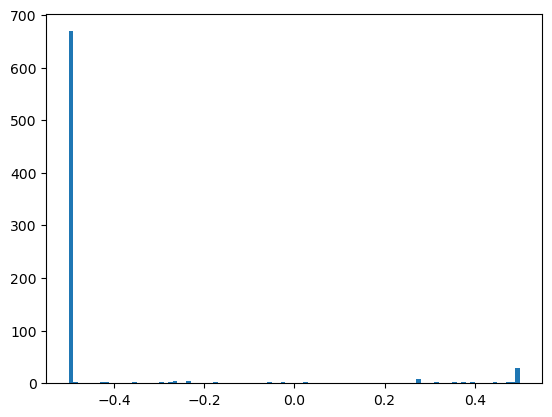

In [26]:
for sample in valid_dataset:
    img, label = sample
    print(type_len(img))
    print(type_len(label))
    print(img.shape, label.shape)
    plt.hist(img.flatten(), bins=100)
    break

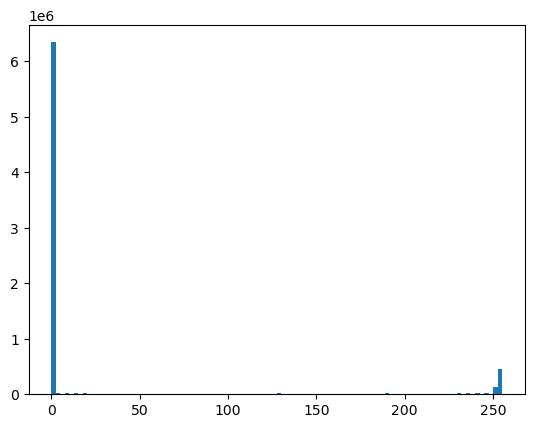

In [27]:
plt.hist(valid_dataset.data.numpy().flatten(), bins=100);

In [28]:
valid_loader

In [29]:
for sample in valid_loader:
    noisy_img, img, label = sample
    print(type_len(noisy_img))
    print(type_len(img))
    print(type_len(label))
    print(noisy_img.shape, img.shape, label.shape)
    #plt.hist(img.flatten(), bins=100)
    break

type: <class 'torch.Tensor'>, len: 128
None
type: <class 'torch.Tensor'>, len: 128
None
type: <class 'torch.Tensor'>, len: 128
None
torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 28, 28]) torch.Size([128])


In [30]:
for s in train_loader:
  xns, xs, ys = s
  print(xns.shape, xs.shape, ys.shape)
  break

torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 28, 28]) torch.Size([128])


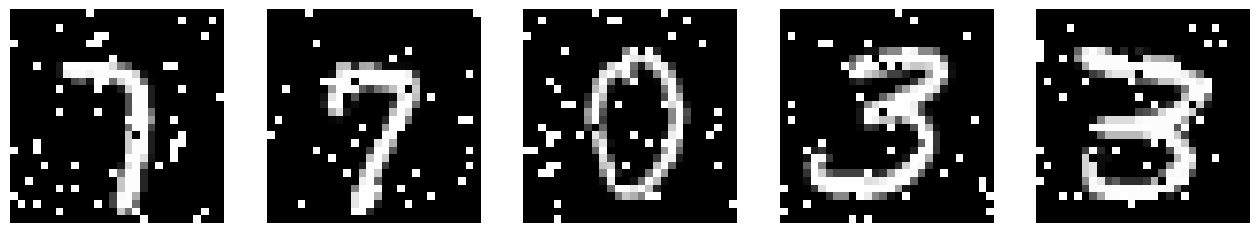

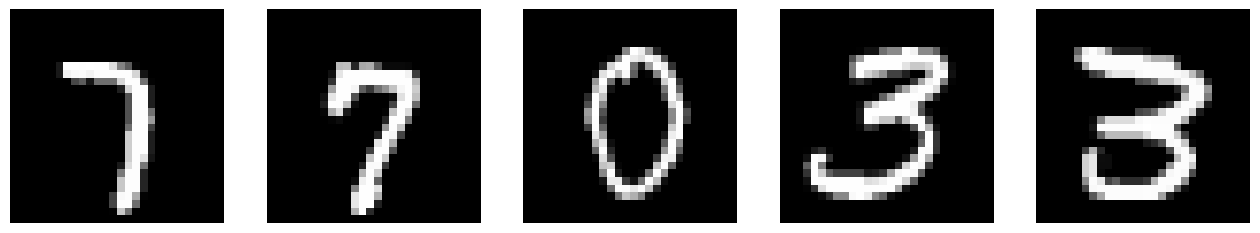

In [32]:
plot_im_samples(xns, is_torch=True)
plot_im_samples(xs, is_torch=True)

In [34]:
# fill array of all preprocessed training samples, converted to numpy:
train_images = []
for batch_idx, (noisy_data, data, target) in enumerate(train_loader):
    train_images.append(data.detach().cpu().numpy())

train_images = np.concatenate(train_images, axis=0)


In [35]:
print ("train_images.shape = ", train_images.shape)
print ("train_images.dtype = ", train_images.dtype)
print ("train_images.mean/std() = ", get_mean_std(train_images))
print ("train_images.min/max() = ", get_min_max(train_images))

train_images.shape =  (59904, 1, 28, 28)
train_images.dtype =  float32
train_images.mean/std() =  (-0.36934593, 0.30810162)
train_images.min/max() =  (-0.5, 0.5)


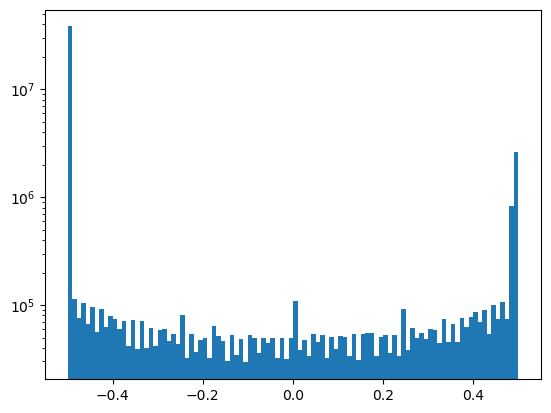

In [36]:
plt.hist(train_images.flatten(), bins=100, log=True);

In [37]:
del train_images

We will also prepare a subsampled dataset from the validation set for the visualisation purpose.

In [38]:
def get_samples(valid_loader):
  # 1. get numpy array of all validation images:
  val_images_noisy = []
  val_images = []
  val_labels = []

  for batch_idx, (noisy_data, data, target) in enumerate(valid_loader):
      val_images_noisy.append(noisy_data.detach().cpu().numpy())
      val_images.append(data.detach().cpu().numpy())
      val_labels.append(target.detach().cpu().numpy())

  val_images_noisy = np.concatenate(val_images_noisy, axis=0)
  val_images = np.concatenate(val_images, axis=0)
  val_labels = np.concatenate(val_labels, axis=0)

  # 2. get numpy array of balanced validation samples for visualization:
  sample_images_noisy = []
  sample_images = []
  sample_labels = []
  single_el_idx = []  # indexes of single element per class for visualization

  n_class = np.max(val_labels) + 1
  for class_idx in range(n_class):
    map_c = val_labels == class_idx

    ims_c_noisy = val_images_noisy[map_c]
    ims_c = val_images[map_c]

    samples_idx = np.random.choice(len(ims_c), N_SAMPLE, replace=False)

    ims_c_noisy_samples = ims_c_noisy[samples_idx]
    ims_c_samples = ims_c[samples_idx]

    sample_images_noisy.append(ims_c_noisy_samples)
    sample_images.append(ims_c_samples)

    sample_labels.append([class_idx]*N_SAMPLE)

    start_idx = N_SAMPLE*class_idx
    single_el_idx.extend([start_idx + i for i in range(min(N_VIS_SAMPLE, N_SAMPLE))])

  sample_images_noisy = np.concatenate(sample_images_noisy, axis=0)
  sample_images = np.concatenate(sample_images, axis=0)
  sample_labels = np.concatenate(sample_labels, axis=0)
  single_el_idx = np.array(single_el_idx)

  samples = {
      'images_noisy': sample_images_noisy,
      'images': sample_images,
      'labels': sample_labels,
      'single_el_idx': single_el_idx

  }
  return samples

In [39]:
samples = get_samples(valid_loader)

In [40]:
samples['images'].shape, samples['labels'].shape

((320, 1, 28, 28), (320,))

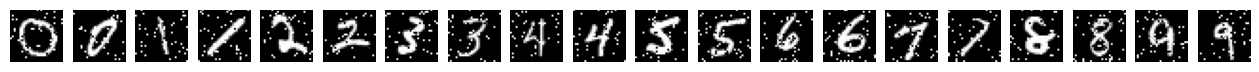

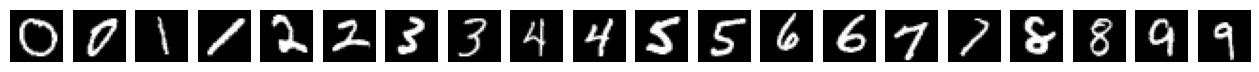

In [41]:
single_el_idx = samples['single_el_idx']
plot_im_samples(samples['images_noisy'][single_el_idx, 0], n=20, is_torch=False)
plot_im_samples(samples['images'][single_el_idx, 0], n=20, is_torch=False)

## Helper Autoencoder Interface

We will start from implementing an Autoencoder model base class

In [42]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, code_size):
        self.input_size = list(input_size)  # shape of data sample
        self.flat_data_size = np.prod(self.input_size)
        self.hidden_size = 128

        self.code_size = code_size  # code size

        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),

            nn.Linear(self.flat_data_size, self.hidden_size),
            nn.ReLU(),

            nn.Linear(self.hidden_size, self.code_size),
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.code_size, self.hidden_size),
            nn.ReLU(),

            nn.Linear(self.hidden_size, self.flat_data_size),
            nn.Tanh(),  # Think: why tanh?

            nn.Unflatten(1, self.input_size),
        )

    def forward(self, x, return_z=False):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return (decoded, encoded) if return_z else decoded

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)*1.1

    def get_n_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


def eval_on_samples(ae_model, epoch, samples):
    # this is called on end of each training epoch
    xns = samples['images_noisy']
    xns = torch.tensor(xns, dtype=torch.float32).to(device)
    #labels = samples['labels']

    with torch.no_grad():
        yz = ae_model(xns, return_z=True)
        yz = [el.detach().cpu().numpy() for el in yz]

        y = yz[0]
        z = yz[1:]

    res = {'z': z, 'y': y, 'epoch': epoch}
    return res

In [43]:
def plot_hist(history, logscale=True):
    """
    plot training loss
    """

    loss = history['loss']
    v_loss = history['val_loss']
    epochs = history['epoch']

    plot = plt.semilogy if logscale else plt.plot
    plot(epochs, loss, label='training');
    plot(epochs, v_loss, label='validation');
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    plt.close()

def plot_samples(sample_history, samples, epoch_stride=5, fig_scale=1):
    """
    Plots input, noisy samples (for DAE) and reconstruction.
    Each `epoch_stride`-th epoch
    """

    single_el_idx = samples['single_el_idx']
    images_noisy = samples['images_noisy'][single_el_idx, 0]
    images = samples['images'][single_el_idx, 0]

    last_epoch = np.max(list(sample_history.keys()))

    for epoch_idx, hist_el in sample_history.items():
      if epoch_idx % epoch_stride != 0 and epoch_idx != last_epoch:
        continue

      samples_arr = [images_noisy, hist_el['y'][single_el_idx, 0], images]

      ny = len(samples_arr)
      nx = len(samples_arr[0])

      plt.figure(figsize=(fig_scale*nx, fig_scale*ny))
      m = mosaic(samples_arr)

      plt.title(f'after epoch {int(epoch_idx)}')
      plt.imshow(m, cmap='gray', vmin=-.5, vmax=.5)
      plt.tight_layout(pad=0.1, h_pad=0, w_pad=0)
      plt.show()
      plt.close()

In [44]:
def run_on_trained(model, root_dir, run_fn, ep=None, model_filename=None):
    """
    Helper function to excecute any function on model in state after `ep` training epoch
    """

    if model_filename is None:
        if ep is not None:
            model_filename = root_dir/f'model_{ep:03d}.pth'
        else:
            model_filename = sorted(list(root_dir.glob('*.pth')))[-1]  # last model state

    model_dict = torch.load(model_filename)

    model.load_state_dict(model_dict['model_state_dict'])

    run_fn(model)

def run_on_all_training_history(model, root_dir, run_fn, n_ep=None):
    """
    Helper function to excecute any function on model state after each of the training epochs
    """
    if n_ep is not None:
        for ep in range(n_ep):
            print(f'running on epoch {ep+1}/{n_ep}...')
            run_on_trained(model, root_dir, run_fn, ep=ep)
    else:
        for model_filename in sorted(root_dir.glob('*.pth')):
            print(f'running on checkpoint {model_filename}...')
            run_on_trained(model, root_dir, run_fn, model_filename=model_filename)
    print(f'done')

sample shapes: torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 28, 28]) torch.Size([128])
output shape: torch.Size([128, 1, 28, 28])


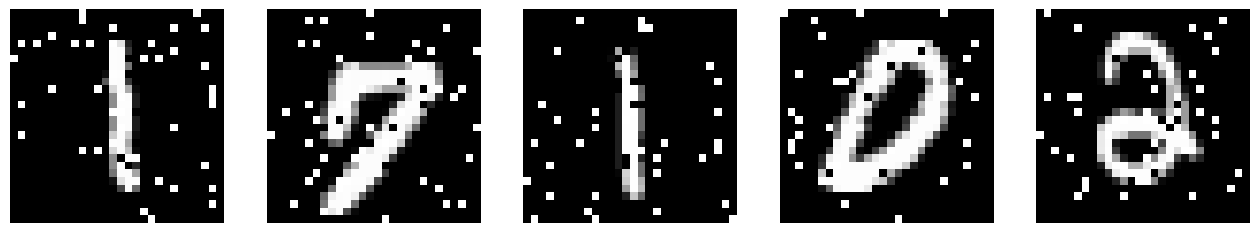

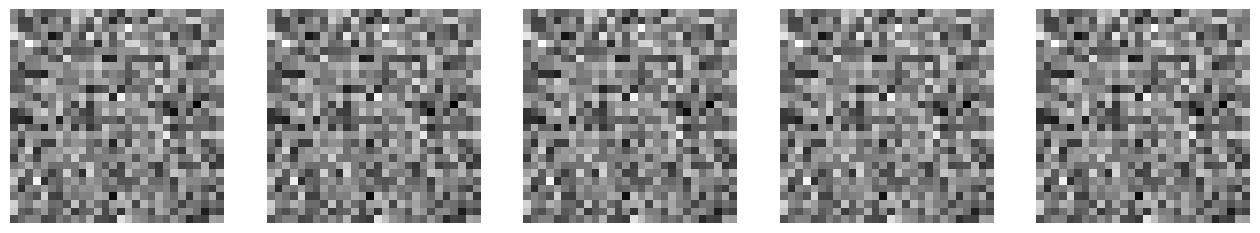

In [45]:
train_batch = next(iter(train_loader))
xns, xs, ys = train_batch
print('sample shapes:', xns.shape, xs.shape, ys.shape)
in_size = xns.shape[1:]

ae = AutoEncoder(input_size=in_size, code_size=10).to(device)
y = ae(xns)
print('output shape:', y.shape)
plot_im_samples(xns, is_torch=True)
plot_im_samples(y, is_torch=True)

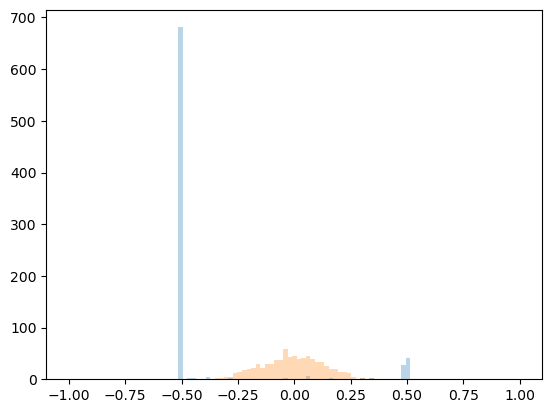

In [46]:
x = xns[0]# - y[1]
d = y[0]# - y[1]

im0 = x[0].detach().cpu().numpy()
im1 = d[0].detach().cpu().numpy()

# plt.imshow(im, cmap='gray', vmin=-1, vmax=1)
bins = np.linspace(-1, 1, 100)
plt.hist(im0.flatten(), bins, alpha=0.3);
plt.hist(im1.flatten(), bins, alpha=0.3);


In [47]:
ae.get_n_params()

204314

# Simple Autoencoder

First we train create an autoencoder with 5 latent variables for MNIST dataset.
Each image is 28x28 pixels.
We start from image data since it's easy to interpret and judge the reconstruction quality visually, but the very same applies to other data types.

In [53]:
CODE_SIZE = 5
NOISE_RATE = 0
MODEL_NAME = 'ae_model'
model = AutoEncoder(input_size=in_size, code_size=CODE_SIZE).to(device)

samples = get_samples(valid_loader)

In [54]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=5, bias=True)
    (4): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Tanh()
    (4): Unflatten(dim=1, unflattened_size=[1, 28, 28])
  )
)

Train the model for 50 epochs

In [55]:
# train the autoencoder model, for N_EPOCHS epochs,
# save history of loss values for training and validation sets,
# history of validation samples evolution, and model weights history,

N_EPOCHS = 50
LR = 0.0009


model_root = pl.Path(MODEL_NAME)
model_root.mkdir(exist_ok=True)



optimizer = optim.Adam(model.parameters(), lr=LR)

# implement loss explicitly
loss = nn.MSELoss()

# train the model
history = {'loss': [], 'val_loss': [], 'epoch': []}
sample_history = {}

pbar = tqdm.tqdm(range(N_EPOCHS), postfix=f'epoch 0/{N_EPOCHS}')
for epoch_idx in pbar:
    epoch_loss = 0
    model.train()
    for batch_idx, (noisy_data, data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(noisy_data)
        loss_value = loss(output, data)
        loss_value.backward()
        optimizer.step()
        epoch_loss += loss_value.detach().cpu().item()
    epoch_loss /= len(train_loader)
    history['loss'].append(epoch_loss)
    history['epoch'].append(epoch_idx)
    # update progress bar

    # evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_idx, (noisy_data, data, target) in enumerate(valid_loader):
            output = model(noisy_data)
            loss_value = loss(output, data)
            val_loss += loss_value.detach().cpu().item()
        val_loss /= len(valid_loader)
        history['val_loss'].append(val_loss)

    pbar.set_postfix({'epoch': f'{epoch_idx+1}/{N_EPOCHS}', 'loss':f'{epoch_loss:.4f}', 'val_loss':f'{val_loss:.4f}'})
    # evaluate on samples
    sample_res = eval_on_samples(model, epoch_idx, samples=samples)
    sample_history[epoch_idx] = sample_res

    # save model weights
    torch.save({
                'epoch': epoch_idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                }, model_root/f'model_{epoch_idx:03d}.pth')

  0%|          | 0/50 [00:00<?, ?it/s, epoch 0/50]

Plot loss function evolution during training:

In [ ]:
plot_hist(history)

Let's visually compare network's output with the input

In [ ]:
plot_samples(sample_history, samples=samples, epoch_stride=5, fig_scale=1)

In [ ]:
sample_history[49]['z'][0].T.shape

In [ ]:
for d in sample_history[49]['z'][0].T:
  plt.hist(d, 100, alpha=0.3);

# Denoising Autoencoder

In denoising AE we create noisy samples and ask the model to reconstruct original (clean) samples. Here 20% of pixels will be corrupted.
This forces the model to learn more robust representations.

In [ ]:
CODE_SIZE = 5
NOISE_RATE = 0.2
MODEL_NAME = 'dae_model'
model = AutoEncoder(input_size=in_size, code_size=CODE_SIZE).to(device)

samples = get_samples(valid_loader)

In [ ]:
model

Train the model for 50 epochs

In [ ]:
# train the autoencoder model, for N_EPOCHS epochs,
# save history of loss values for training and validation sets,
# history of validation samples evolution, and model weights history,

N_EPOCHS = 15
LR = 0.0009


model_root = pl.Path(MODEL_NAME)
model_root.mkdir(exist_ok=True)



optimizer = optim.Adam(model.parameters(), lr=LR)

# implement loss explicitly
loss = nn.MSELoss()

# train the model
history = {'loss': [], 'val_loss': [], 'epoch': []}
sample_history = {}

pbar = tqdm.tqdm(range(N_EPOCHS), postfix=f'epoch 0/{N_EPOCHS}')
for epoch_idx in pbar:
    epoch_loss = 0
    model.train()
    for batch_idx, (noisy_data, data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(noisy_data)
        loss_value = loss(output, data)
        loss_value.backward()
        optimizer.step()
        epoch_loss += loss_value.detach().cpu().item()
    epoch_loss /= len(train_loader)
    history['loss'].append(epoch_loss)
    history['epoch'].append(epoch_idx)
    # update progress bar

    # evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_idx, (noisy_data, data, target) in enumerate(valid_loader):
            output = model(noisy_data)
            loss_value = loss(output, data)
            val_loss += loss_value.detach().cpu().item()
        val_loss /= len(valid_loader)
        history['val_loss'].append(val_loss)

    pbar.set_postfix({'epoch': f'{epoch_idx+1}/{N_EPOCHS}', 'loss':f'{epoch_loss:.4f}', 'val_loss':f'{val_loss:.4f}'})
    # evaluate on samples
    sample_res = eval_on_samples(model, epoch_idx, samples=samples)
    sample_history[epoch_idx] = sample_res

    # save model weights
    torch.save({
                'epoch': epoch_idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                }, model_root/f'model_{epoch_idx:03d}.pth')

Plot loss function evolution during training:

In [ ]:
plot_hist(history)

Visualise evolution of reconstruction:

In [ ]:
plot_samples(sample_history, samples=samples, epoch_stride=5, fig_scale=1)

## Exercise 1

Use autoencoder to find outliers:
1. preform reconstruciton for test dataset
2. evaluate reconstruction loss and plot distrubution ()
3. visualise poorely reconstructed samples

Extra/Homework:
Perform 2D UMAP embedding of the raw data points and image encoding (variables in latent space) for test set, plot it and highlight outliers.

# Convolutional autoencoder

Instead of fully connected layers we can use strided convolutional layers in encoder, and transposed convolutions in decoder.
This model will have less parameters due to the weight sharing, thus easier to train.

After upscaling the image size will be a bit bigger then original, so we also crop reconstruction to the input image size.

In [ ]:
class ConvolutionalAutoEncoder(AutoEncoder):
    def __init__(self, input_size, code_size):
        self.input_size = list(input_size)  # shape of data sample

        self.hidden_size = 32*2*2

        self.code_size = code_size  # code size

        super(ConvolutionalAutoEncoder, self).__init__(input_size, code_size)
        self.encoder = nn.Sequential(
            nn.Conv2d(1,   8, 3, padding=1, stride=1), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(8,   8, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(8,  16, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(16, 16, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),

            nn.Flatten(),

            nn.Linear(self.hidden_size, self.hidden_size//8), nn.LeakyReLU(negative_slope=0.3),
            nn.Linear(self.hidden_size//8, self.code_size),
            # nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.code_size, self.hidden_size), nn.LeakyReLU(negative_slope=0.3),

            nn.Unflatten(1, (32, 2, 2)),

            nn.ConvTranspose2d(32, 16, 3, padding=1, output_padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.ConvTranspose2d(16, 16, 3, padding=1, output_padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.ConvTranspose2d(16,  8, 3, padding=1, output_padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.ConvTranspose2d(8,   8, 3, padding=1, output_padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(8, 1, 3, padding=1, stride=1), nn.Tanh(),
        )

    def decode(self, z):
        reconstruction = self.decoder(z)
        reconstruction = reconstruction[:, :, 2:-2, 2:-2]
        return reconstruction


Thus we can try to reduce sise of the latent space:

In [ ]:
CODE_SIZE = 2
NOISE_RATE = 0.2
MODEL_NAME = 'cdae_model'
model = ConvolutionalAutoEncoder(input_size=in_size, code_size=CODE_SIZE).to(device)

samples = get_samples(valid_loader)

In [ ]:
xns = torch.tensor(samples['images_noisy']).to(device)
print(xns.shape)
zs = model.encode(xns)
ys = model(xns)
print(zs.shape)
print(ys.shape)

In [ ]:
model

In [ ]:
model.get_n_params()

Train the model for 20 epochs

In [ ]:
# train the autoencoder model, for N_EPOCHS epochs,
# save history of loss values for training and validation sets,
# history of validation samples evolution, and model weights history,

N_EPOCHS = 50
LR = 0.0004


model_root = pl.Path(MODEL_NAME)
model_root.mkdir(exist_ok=True)



optimizer = optim.Adam(model.parameters(), lr=LR)

# implement loss explicitly
loss = nn.L1Loss()

# train the model
#history = {'loss': [], 'val_loss': [], 'epoch': []}
#sample_history = {}

pbar = tqdm.tqdm(range(N_EPOCHS, N_EPOCHS+20), postfix=f'epoch 0/{N_EPOCHS}')
for epoch_idx in pbar:
    epoch_loss = 0
    model.train()
    for batch_idx, (noisy_data, data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(noisy_data)
        loss_value = loss(output, data)
        loss_value.backward()
        optimizer.step()
        epoch_loss += loss_value.detach().cpu().item()
    epoch_loss /= len(train_loader)
    history['loss'].append(epoch_loss)
    history['epoch'].append(epoch_idx)
    # update progress bar

    # evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_idx, (noisy_data, data, target) in enumerate(valid_loader):
            output = model(noisy_data)
            loss_value = loss(output, data)
            val_loss += loss_value.detach().cpu().item()
        val_loss /= len(valid_loader)
        history['val_loss'].append(val_loss)

    pbar.set_postfix({'epoch': f'{epoch_idx+1}/{N_EPOCHS}', 'loss':f'{epoch_loss:.4f}', 'val_loss':f'{val_loss:.4f}'})
    # evaluate on samples
    sample_res = eval_on_samples(model, epoch_idx, samples=samples)
    sample_history[epoch_idx] = sample_res

    # save model weights
    torch.save({
                'epoch': epoch_idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                }, model_root/f'model_{epoch_idx:03d}.pth')

Plot loss function evolution during training:

In [ ]:
plot_hist(history)

Visualise evolution of reconstruction:

In [ ]:
plt.hist(samples['images'].flatten(), bins=100, log=True);
for k in ['y', 'z']:
    #print(sample_history[0][k].shape)
    plt.hist(np.array(sample_history[0][k]).flatten(), bins=100, log=True, alpha=0.3);
    plt.hist(np.array(sample_history[epoch_idx-1][k]).flatten(), bins=100, log=True, alpha=0.3);
    plt.show()
    plt.close()



In [ ]:
plot_samples(sample_history, samples=samples, epoch_stride=5, fig_scale=1)

## Latent space

So far we looked just on the output: the model sort of does the job. But what does it learn?

First let's use animation to visualize reconstruction evolution:

In [ ]:
%%capture

single_el_idx = samples['single_el_idx']
images_noisy = samples['images_noisy'][single_el_idx, 0]
images = samples['images'][single_el_idx, 0]

smpl_ims = []
for epoch_idx, hist_el in sample_history.items():
    samples_arr = [images_noisy, hist_el['y'][single_el_idx, 0], images]
    smpl_ims.append(samples_arr)

ny, nx = len(smpl_ims[0]), len(smpl_ims[0][0])

plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above animations use JavaScript

s=1
fig = plt.figure(figsize=(s*nx, s*ny))

m = mosaic(smpl_ims[0])

ttl = plt.title(f'after epoch {int(0)}')
# plot 0th epoch - 0th frame
imsh = plt.imshow(m, cmap='gray', vmin=-0.5, vmax=0.5)

# this function will be called to render each of the frames
def animate(i):
    m = mosaic(smpl_ims[i])
    imsh.set_data(m)

    ttl.set_text(f'after epoch {i}')

    return imsh

# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(smpl_ims))

In [ ]:
# display animation
ani

And let's see evolution of the latent representations:

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript
fig = plt.figure(figsize=(8,8))

labels = samples['labels']
epochs = sorted(sample_history.keys())
z_res = [sample_history[ep]['z'][0] for ep in epochs]


scat = plt.scatter(z_res[0][:,0], z_res[0][:,1], c=labels, cmap=cm.rainbow)
plt.xlim(-6.1, 6.1)
plt.ylim(-6.1, 6.1)

ax = plt.gca()
legend1 = ax.legend(*scat.legend_elements(), title="digits")
ax.add_artist(legend1)
ax.set_aspect('equal')
ttl = plt.title(f'after epoch {0}')

def animate(i):
    z = z_res[i]
    scat.set_offsets(z)
    ttl.set_text(f'after epoch {i}')
    return scat

ani = animation.FuncAnimation(fig, animate, frames=len(z_res))

In [ ]:
ani

## Sampling from latent space

But we can also use the trained model to generate samples based on the latent representation:

In [ ]:
z0 = np.random.uniform(size=(25, CODE_SIZE))*12-6  # get 20 random points in 2D sampled from uniform distribution between 0 and 1
z0_t = torch.tensor(z0, dtype=torch.float32).to(device)

ims_all = []

# this function will be called in saved model state after each training epoch
def fn(ae):
  with torch.no_grad():
    ims = ae.decode(z0_t)
    ims = ims.detach().cpu().numpy()
    ims_all.append(ims)

run_on_all_training_history(model, model_root, fn)

ims_all = np.array(ims_all)
print(ims_all.shape)
ims_all = ims_all[:, :, 0, :, :]  # remove channel dimension

In [ ]:
plt.hist(ims_all[0].flatten(), bins=100, log=True);
plt.hist(ims_all[-1].flatten(), bins=100, log=True, alpha=0.5);


In [ ]:
%%capture
fig = plt.figure(figsize=(20, 1.5))

m = mosaic([ims_all[0]])

imsh = plt.imshow(m, cmap='gray', vmin=0, vmax=1)
ttl = plt.title(f'after epoch {int(0)}')


def animate(i):
    m = mosaic([ims_all[i]])
    imsh.set_data(m)
    ttl.set_text(f'after epoch {i}')
    return imsh

ani = animation.FuncAnimation(fig, animate, frames=len(ims_all))

In [ ]:
ani

## Interpolation in latent space

In [ ]:
n_samples = 10
zs = np.meshgrid(np.linspace(-6, 6, n_samples),
                 np.linspace(-6, 6, n_samples))
zs = np.stack(zs, axis=-1).reshape(-1, 2)
zs_t = torch.tensor(zs, dtype=torch.float32).to(device)

In [ ]:
def fn(ae):
  with torch.no_grad():
    ims_t = ae.decode(zs_t)
    ims = ims_t.detach().cpu().numpy()
    ims = ims[:, 0, :, :]  # remove channel dimension

  sh = list(ims.shape)
  ims = ims.reshape([n_samples, n_samples]+sh[1:])
  plt.figure(figsize=(10, 10))

  # here image order is reversed along y axis in `ims` to match y axis direction on the plot
  # (y axis goes from bottom to top, while pixel order - from top to bottom)
  plt.imshow(mosaic(ims[::-1]), vmin=0, vmax=1, cmap='gray')
  plt.show()

run_on_trained(model, model_root, fn)


## Exercise 2


Work in 2 groups:


Option 1. Compare distribution in latent space for noise rate 0, 0.2, 0.6, 0.8.

Option 2. Compare reconstruction depending on size of latent space: 2, 4, 8, 16, 32

## Exercise 3: Writing latent Dataset


In this exercise, we will
1. modify the CNN to be fully convolutional, with 4 downscaling layers (x16), 16 channels
2. save dataset of latent states, see code below for example.

When usuing VAE - save the Z nean and log std - separately

In [ ]:
import pickle

def save_pckl(obj, fname):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.DEFAULT_PROTOCOL)

def load_pckl(fname):
    with open(fname, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [ ]:
#load latest model checkpoint:
run_on_trained(model, model_root, lambda m:None, ep=3)

# dataset for latent DDM, file list:
data_files = {"train": [], "test": []}

ds_root = pl.Path('data')
ds_root.mkdir(exist_ok=True)

# generate latent values per blocks of samples:
block_sz = 5000
for ds, sfx in zip([valid_dataset, train_dataset], ['test', 'train']):
  x = ds.data.numpy().reshape(-1, 1, 28, 28)
  x = x/255.*2-1
  l = ds.targets.numpy()

  for i in range(0, len(x), block_sz):
    x_b = x[i:i+block_sz]
    l_b = l[i:i+block_sz]

    x_b_t = torch.tensor(x_b, dtype=torch.float32).to(device)

    with torch.no_grad():
        z_t = model.encode(x_b_t)
        z_b = z_t.detach().cpu().numpy()

    # save latent values and their shape and labels to a dataframe:
    data_d = {
    'z': [zi.flatten() for zi in z_b],
    'shape': [zi.shape for zi in z_b],
    'label': l_b
    }

    df = pd.DataFrame(data=data_d)

    # save dataframe to a file and reference dictioanry:
    fname = ds_root/f'df_z_{sfx}_{i}.pckl'
    save_pckl(df, fname)
    data_files[sfx].append(str(fname))

save_pckl(data_files, ds_root/'data_files.pkl')

In [ ]:
from datasets import load_dataset, Dataset

In [ ]:
# now we can load the dataset:
data_files = load_pckl(ds_root/'data_files.pkl')
lds = load_dataset('pandas', data_files=data_files)

In [ ]:
# convert to torch dataset:
tds = lds.with_format("torch")

In [ ]:
tds['train']['z'].shape

# VAE

While the previous model learn to seaparate subpopulations in the latent space, there remains significant overlap & unpopulated regions.

Varitional AE puts additional constraints on the distribution in the latent space and perform variational inference.

(see pptx for details)

Here the encoder will predict `2 x n_code` values: means and logarithm of variance for each sample. Since these values live in $R^2$ - no activation function is used in last layer of the encoder.

Then for reconstruction we will sample from this distribuition with a reparametrisation trick.

The tecnically complex part - is to implement the custom loss function and training loop.

In [ ]:
class VariationalConvolutionalAutoencoder(AutoEncoder):
    def __init__(self, input_size, code_size):
        super(VariationalConvolutionalAutoencoder, self).__init__(input_size, code_size)

        # nn.LeakyReLU(negative_slope=0.3)
        self.input_size = list(input_size)  # shape of data sample
        self.npix = np.prod(self.input_size)

        self.hidden_size = 64*1

        self.code_size = code_size  # code size

        self.encoder = nn.Sequential(
            nn.Conv2d(1,   16, 3, padding=1, stride=1), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(16,  16, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(16,  32, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(32,  32, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(32,  32, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(32,  64, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),

            nn.Flatten(),

            nn.Linear(self.hidden_size, 64), nn.LeakyReLU(negative_slope=0.3),

            # we want values in all R, thus no activation function is applied. self.n_code values for mean + self.n_code for log(variance)
            nn.Linear(64, self.code_size * 2),

        )
        self.decoder = nn.Sequential(
            nn.Linear(self.code_size, 64), nn.LeakyReLU(negative_slope=0.3),
            nn.Linear(64, self.hidden_size), nn.LeakyReLU(negative_slope=0.3),

            nn.Unflatten(1, (64, 1, 1)),

            nn.ConvTranspose2d(64, 32, 3, padding=1, output_padding=1, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, padding=1, output_padding=1, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, padding=1, output_padding=1, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, padding=1, output_padding=1, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 3, padding=1, output_padding=1, stride=2), nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1, stride=1), nn.Tanh(),
        )

    def sample(self, eps=None):
        if eps is None:
            # samle from standard normal distribution
            eps = torch.randn((100, self.code_size))
        return self.decode(eps)

    def encode(self, x):
        z = self.encoder(x)
        z_mean, z_logvar = torch.split(z, split_size_or_sections=2, dim=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        # reaparametrization trick: to sample z from N(mean, std):
        # z = mean + std * eps, where eps sampled from N(0, 1)
        eps = torch.randn_like(z_mean)
        z_std = torch.exp(z_logvar * .5)
        return eps * z_std + z_mean

    def decode(self, z):
        reconstruction = self.decoder(z)
        reconstruction = reconstruction[:, :, 2:-2, 2:-2]
        return reconstruction

    def forward(self, x, return_z=False):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        reconstruction = self.decode(z)
        return (reconstruction, z_mean, z_logvar) if return_z else reconstruction

    def forward_and_KL_loss(self, x, y):
        reconstruction, z_mean, z_logvar = self(x, return_z=True)

        # tf impl:
        # loss_z_kl = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + tf.square(z_mean) -1.0 - z_logvar, axis=1)  # KL divergence from N(0, 1) to N(z_mean, tf.exp(z_logvar * .5))
        # loss_z_kl = tf.reduce_mean(loss_z_kl) / np.prod(self.data_size)  # but since we used mean in reconstruction loss - this term has to be normalized accordingly

        # pytorch impl:
        loss_z_kl = 0.5 * torch.sum(torch.exp(z_logvar) + torch.square(z_mean) -1.0 - z_logvar, dim=1)
        loss_z_kl = torch.mean(loss_z_kl) / self.npix

        return reconstruction, loss_z_kl


In [ ]:
CODE_SIZE = 2 # 50
NOISE_RATE = 0.
MODEL_NAME = 'vcae_model'
model = VariationalConvolutionalAutoencoder(input_size=in_size, code_size=CODE_SIZE).to(device)

samples = get_samples(valid_loader)

In [ ]:
xns = torch.tensor(samples['images_noisy']).to(device)
print(xns.shape)
ys = model(xns)
ys.shape

In [ ]:
model

In [ ]:
model.get_n_params()

In [ ]:
# train the autoencoder model, for N_EPOCHS epochs,
# save history of loss values for training and validation sets,
# history of validation samples evolution, and model weights history,

N_EPOCHS = 4 # 20
LR = 0.0009


model_root = pl.Path(MODEL_NAME)
model_root.mkdir(exist_ok=True)



optimizer = optim.Adam(model.parameters(), lr=LR)

# implement loss explicitly
loss = nn.MSELoss()

# train the model
history = {'loss': [], 'val_loss': [], 'rec_loss': [], 'rec_val_loss': [], 'kl_loss': [], 'kl_val_loss': [], 'epoch': []}
sample_history = {}

pbar = tqdm.tqdm(range(N_EPOCHS), postfix=f'epoch 0/{N_EPOCHS}')
for epoch_idx in pbar:
    epoch_loss = 0
    epoch_rec_loss = 0
    epoch_kl_loss = 0

    model.train()
    for batch_idx, (noisy_data, data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        #output = model(noisy_data)
        output, kl_loss = model.forward_and_KL_loss(noisy_data, data)
        rec_loss = loss(output, data)
        loss_value = rec_loss + kl_loss
        loss_value.backward()
        optimizer.step()

        epoch_loss += loss_value.detach().cpu().item()
        epoch_rec_loss += rec_loss.detach().cpu().item()
        epoch_kl_loss += kl_loss.detach().cpu().item()

    n_elements = len(train_loader)

    epoch_loss /= n_elements
    epoch_rec_loss /= n_elements
    epoch_kl_loss /= n_elements

    history['loss'].append(epoch_loss)
    history['rec_loss'].append(epoch_rec_loss)
    history['kl_loss'].append(epoch_kl_loss)

    history['epoch'].append(epoch_idx)
    # update progress bar

    # evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_rec_loss = 0
        val_kl_loss = 0

        for batch_idx, (noisy_data, data, target) in enumerate(valid_loader):
            #output = model(noisy_data)
            output, kl_loss = model.forward_and_KL_loss(noisy_data, data)
            rec_loss = loss(output, data)
            loss_value = rec_loss + kl_loss

            val_loss += loss_value.detach().cpu().item()
            val_rec_loss += rec_loss.detach().cpu().item()
            val_kl_loss += kl_loss.detach().cpu().item()

        val_loss /= len(valid_loader)
        val_rec_loss /= len(valid_loader)
        val_kl_loss /= len(valid_loader)

        history['val_loss'].append(val_loss)
        history['rec_val_loss'].append(val_rec_loss)
        history['kl_val_loss'].append(val_kl_loss)

    pbar.set_postfix({'epoch': f'{epoch_idx+1}/{N_EPOCHS}', 'loss':f'{epoch_loss:.4f}', 'val_loss':f'{val_loss:.4f}'})
    # evaluate on samples
    sample_res = eval_on_samples(model, epoch_idx, samples=samples)
    sample_history[epoch_idx] = sample_res

    # save model weights
    torch.save({
                'epoch': epoch_idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                }, model_root/f'model_{epoch_idx:03d}.pth')

In [ ]:
model

In [ ]:
plot_hist(history)

In [ ]:
plot_samples(sample_history, samples=samples, epoch_stride=5, fig_scale=1)

Visualize reconstruciton:

In [ ]:
%%capture

single_el_idx = samples['single_el_idx']
images_noisy = samples['images_noisy'][single_el_idx, 0]
images = samples['images'][single_el_idx, 0]

smpl_ims = []
for epoch_idx, hist_el in sample_history.items():
    samples_arr = [images_noisy, hist_el['y'][single_el_idx, 0], images]
    smpl_ims.append(samples_arr)

ny, nx = len(smpl_ims[0]), len(smpl_ims[0][0])

plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above animations use JavaScript

s=1
fig = plt.figure(figsize=(s*nx, s*ny))

m = mosaic(smpl_ims[0])

ttl = plt.title(f'after epoch {int(0)}')
# plot 0th epoch - 0th frame
imsh = plt.imshow(m, cmap='gray', vmin=0, vmax=1)

# this function will be called to render each of the frames
def animate(i):
    m = mosaic(smpl_ims[i])
    imsh.set_data(m)

    ttl.set_text(f'after epoch {i}')

    return imsh

# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(smpl_ims))

In [ ]:
ani

Let's look at the latent representation:

In [ ]:
sample_history[0]['z'][0].shape

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript
fig = plt.figure(figsize=(8,8))

smpl_epochs = list(sample_history.keys())

z_res_mean = [sample_history[ep]['z'][0] for ep in smpl_epochs]
z_logvar = [sample_history[ep]['z'][1] for ep in smpl_epochs]
z_res_std = np.exp(np.array(z_logvar) * .5)


l_res = samples['labels']
l_col = [cm.rainbow(l_i/10) for l_i in l_res]

# error bars:
def get_lines(m, s):
  l = []
  for (x, y), (sx, sy) in zip(m, s):
    l.append([(x-sx, y), (x+sx, y)]) # h
    l.append([(x, y-sy), (x, y+sy)]) # w
  return np.array(l)

lines = get_lines(z_res_mean[0], z_res_std[0])
lc = mc.LineCollection(lines, color=l_col, linewidths=2, alpha=0.3)
fig.gca().add_collection(lc)

scat = plt.scatter(z_res_mean[0][:,0], z_res_mean[0][:,1], c=l_res, cmap=cm.rainbow)
#scat_err = plt.errorbar(z_res_mean[0][:,0], z_res_mean[0][:,1], xerr=z_res_std[0][:,0], yerr=z_res_std[0][:,1], fmt="o")

plt.xlim(-4, 4)
plt.ylim(-4, 4)

legend1 = plt.gca().legend(*scat.legend_elements(), title="digits")
plt.gca().add_artist(legend1)
plt.gca().set_aspect('equal')
ttl = plt.title(f'after epoch {0}')

def animate(i):
    z = z_res_mean[i]
    scat.set_offsets(z)

    lines = get_lines(z_res_mean[i], z_res_std[i])
    lc.set_segments(lines)

    ttl.set_text(f'after epoch {i}')
    return scat, lc

ani = animation.FuncAnimation(fig, animate, frames=len(z_res_mean))

In [ ]:
ani

And let's sample from the latent space:

In [ ]:
zs.shape

In [ ]:
n = 20
zs = np.meshgrid(norm.ppf(np.linspace(0.0001, 0.9999, n)),  # sampling proportionally to the density
                 norm.ppf(np.linspace(0.0001, 0.9999, n)))
# zs = np.meshgrid(np.linspace(-4, 4, n),  # sampling linearly
#                  np.linspace(-4, 4, n))
zs = np.stack(zs, axis=-1)
zs = zs.reshape((-1, 2))

zs_t = torch.tensor(zs, dtype=torch.float32).to(device)

def fn(ae):
  with torch.no_grad():
    ims_t = ae.decode(zs_t)
    ims = ims_t.detach().cpu().numpy()
    ims = ims[:, 0, :, :]  # remove channel dimension

  sh = list(ims.shape)
  ims = ims.reshape([n, n]+sh[1:])
  plt.figure(figsize=(n, n))
  plt.imshow(mosaic(ims[::-1]), vmin=0, vmax=1, cmap='gray')
  plt.show()
  plt.close()

run_on_trained(model, model_root, fn)


In [ ]:
def fn(ae):
  # x = samples['images_noisy']
  # l = samples['labels']
  # ds = valid_dataset
  ds = train_dataset
  x = ds.data.numpy().reshape(-1, 1, 28, 28)
  x = x/255.*2-1
  l = ds.targets.numpy()
  x_t = torch.tensor(x, dtype=torch.float32).to(device)
  z_m, z_s = ae.encode(x_t)
  z_m, z_s = [el.detach().cpu().numpy() for el in [z_m, z_s]]

  z_res_std = np.exp(np.array(z_s) * .5)

  plt.figure(figsize=(10, 10))
  scat = plt.scatter(*z_m.T, c=l, s=2, cmap='jet')
  plt.gca().legend(*scat.legend_elements(), title="digits")
  plt.show()
  plt.close()

  fig, ax = plt.subplots(figsize=(10, 2), ncols=2, nrows=1)
  ax[0].hist(z_m.flatten(), bins=100);
  ax[1].hist(z_res_std.flatten(), bins=100);
  ax[0].set_title('mean')
  ax[1].set_title('std')
  plt.show()
  plt.close()

run_on_trained(model, model_root, fn)


## Visualization excercise (homework)

Option 1: Sample 31x31 and overlay with data points.

Option 2: Visulize data-point in latent space


```
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.figure(figsize=(10,10))
ax = plt.gca()

# given the image sample array `image_arr` and the pair of coordinate arrays
# of the latent representation z0_arr, z1_arr:
for z0_i, z1_i, im_i in zip(z0_arr, z1_arr, image_arr):
    im = OffsetImage(im_i, zoom=0.5)
    ab = AnnotationBbox(im, (z0_i, z1_i), xycoords='data', frameon=False)

    ax.add_artist(ab)
    ax.update_datalim([(z0_i, z1_i)])
    ax.autoscale()

```

## Example of project work

Use VAE to explore Fashion MNIST, or any other dataset
 1. train model
 2. explore latent representation
 3. find outliers
 4. sample from the latent distribution
 5. overlay with data points
 6. Train classifier/regressor using the latent space representation of the samples